# Florence 2 Test

https://huggingface.co/microsoft/Florence-2-base

In [1]:
import requests
import time

import torch
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from transformers import AutoProcessor, AutoModelForCausalLM 

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

In [3]:
model = AutoModelForCausalLM.from_pretrained("microsoft/Florence-2-base", torch_dtype=torch_dtype, trust_remote_code=True).to(device)
processor = AutoProcessor.from_pretrained("microsoft/Florence-2-base", trust_remote_code=True)

In [4]:
prompt = "<OD>"

In [5]:
url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/car.jpg?download=true"
image = Image.open(requests.get(url, stream=True).raw)

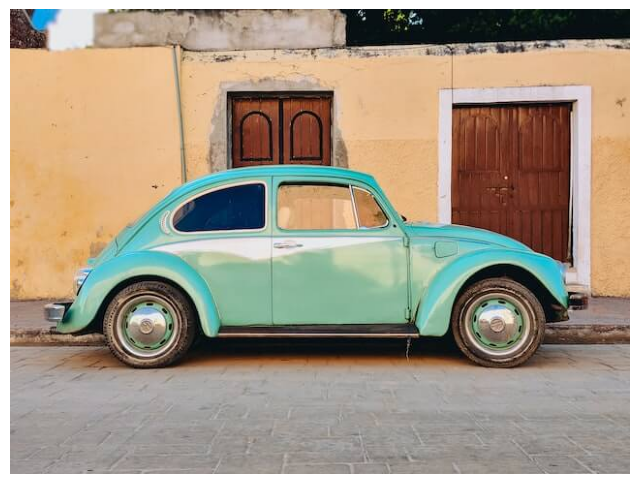

In [6]:
# Display the image
plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.axis('off')
#plt.title("Image")
plt.show()

In [ ]:
inputs = processor(text=prompt, images=image, return_tensors="pt").to(device, torch_dtype)

generated_ids = model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=1024,
    num_beams=3,
    do_sample=False
)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

parsed_answer = processor.post_process_generation(generated_text, task="<OD>", image_size=(image.width, image.height))

print(parsed_answer)

In [ ]:
parsed_answer['<OD>']

In [ ]:
def plot_bbox(image, data):
   # Create a figure and axes
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(image)

    # Plot each bounding box
    for bbox, label in zip(data['bboxes'], data['labels']):
        # Unpack the bounding box coordinates
        x1, y1, x2, y2 = bbox
        # Create a Rectangle patch
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
        # Add the rectangle to the Axes
        ax.add_patch(rect)
        # Annotate the label
        plt.text(x1, y1, label, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))

    # Remove the axis ticks and labels
    ax.axis('off')

    # Show the plot
    plt.show()

In [ ]:
plot_bbox(image, parsed_answer['<OD>'])

In [ ]:
def run_example(task_prompt, text_input=None):
    start_time = time.perf_counter()  # Start timing
    
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input
    inputs = processor(text=prompt, images=image, return_tensors="pt").to(device, torch_dtype)
    generated_ids = model.generate(
      input_ids=inputs["input_ids"],
      pixel_values=inputs["pixel_values"],
      max_new_tokens=1024,
      num_beams=3
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

    parsed_answer = processor.post_process_generation(generated_text, task=task_prompt, image_size=(image.width, image.height))

    print(parsed_answer)

    end_time = time.perf_counter()  # End timing
    elapsed_time = end_time - start_time  # Calculate elapsed time
    print(f" \n[INFO] ==> Florence-2-base ({task_prompt}), took {elapsed_time:.1f} seconds to execute.\n")
    
    return parsed_answer

In [ ]:
prompt = "<CAPTION>"
results = run_example(prompt)

In [ ]:
prompt = "<DETAILED_CAPTION>"
results = run_example(prompt)

In [ ]:
prompt = "<MORE_DETAILED_CAPTION>"
results = run_example(prompt)

In [ ]:
task_prompt = "<CAPTION_TO_PHRASE_GROUNDING>"
results = run_example(task_prompt, text_input="A green car parked in front of a yellow building.")

In [ ]:
results['<CAPTION_TO_PHRASE_GROUNDING>']

In [ ]:
plot_bbox(image, results['<CAPTION_TO_PHRASE_GROUNDING>'])